# Module Project
## Synthesizing raw audio signals to sound like saxophone sounds

In [478]:
import numpy as np
from scipy.io import wavfile
import librosa, librosa.display
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
plt.style.use('seaborn-dark')
%run Util.ipynb
%matplotlib inline
import IPython.display as ipd

/var/folders/wz/njd4pyh975g7stkhmhcy2frr0000gn/T/ipykernel_19089/352002470.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


In [479]:
# Get middle C frequency
note_freqs = get_music_notes()
frequency = note_freqs['C4']

# Pure sine wave
sine_wave = get_sine_wave(frequency, duration=2, amplitude=2048)
wavfile.write('data/pure_c.wav', rate=44100, data=sine_wave.astype(np.int16))

### Visualising pure c4


In [480]:
sample_rate, middle_c = wavfile.read('data/pure_c.wav')

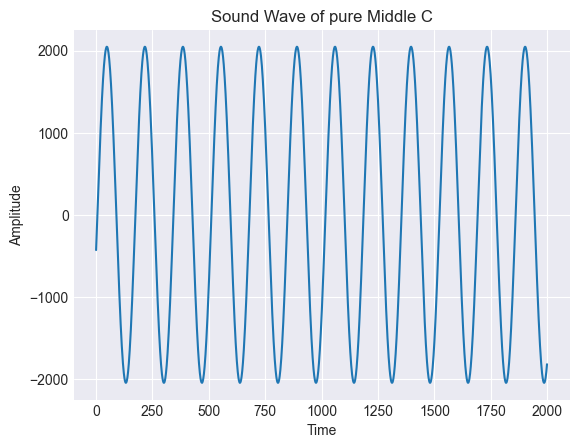

In [261]:
plt.plot(middle_c[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of pure Middle C')
plt.grid()

In [262]:
ipd.Audio(middle_c, rate=44100, normalize=True)

### Visualising saxophone c4

In [69]:
sax_sample_rate, sax_middle_c = wavfile.read('data/sax_c.wav')

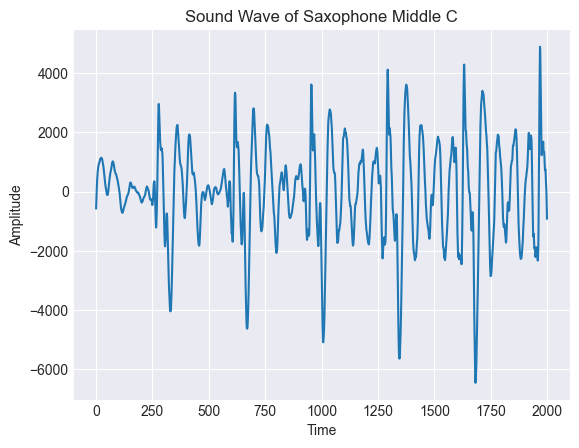

In [72]:
plt.plot(sax_middle_c[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Saxophone Middle C')
plt.grid()

In [73]:
ipd.Audio(sax_middle_c, rate=sax_sample_rate, normalize=True)

### FFT

In [74]:
t = np.arange(sax_middle_c.shape[0])
freq = np.fft.fftfreq(t.shape[-1]) * sax_sample_rate
sp = np.fft.fft(sax_middle_c)

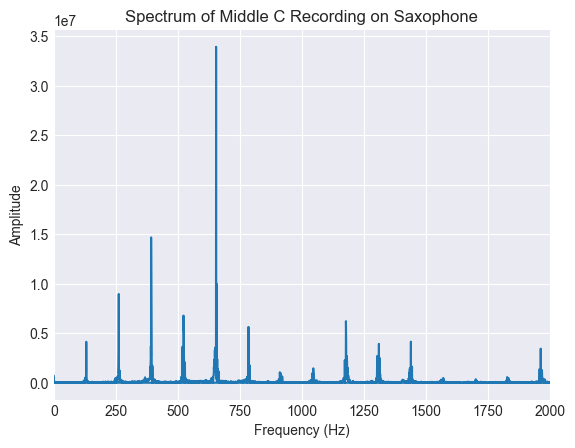

In [75]:
# Plot spectrum
plt.plot(freq, abs(sp.real))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum of Middle C Recording on Saxophone')
plt.xlim((0, 2000))
plt.grid()
plt.savefig('data/spectrum.jpg')

Notes on this graph:
<br>
- The notes are evenly-spaced
- They occur just under every 250/2 frequency samples

<br>

We need to create factors of the dominant frequency against the actual frequency. We then use this to create overtones

## Formula 1

In [421]:
t = np.arange(sax_middle_c.shape[0])
freq = np.fft.fftfreq(t.shape[-1]) * sax_sample_rate
sp = np.fft.fft(sax_middle_c)

In [481]:
# Get positive frequencies
idx = np.where(freq > 0)[0]
freq = freq[idx]
sp = sp[idx]

# Get dominant frequencies
sort = np.argsort(-abs(sp.real))[:100]
dom_freq = freq[sort]

# Calculate the frequency ratios and amplitude ratios for the saxophone note
freq_ratio = np.round(dom_freq / frequency)
unique_freq_ratio = np.unique(freq_ratio)
amp_ratio = abs(sp.real[sort] / np.sum(sp.real[sort]))

# Construct the sax_factor
sax_factor = np.zeros((int(unique_freq_ratio[-1]), ))
for i in range(sax_factor.shape[0]):
    idx = np.where(freq_ratio == i + 1)[0]
    sax_factor[i] = np.sum(amp_ratio[idx])
sax_factor = sax_factor / np.sum(sax_factor)

# Now use the sax_factor with your apply_overtones function
sax_note_with_overtones = apply_saxophone_overtones(frequency, duration=2.0, sax_factor=sax_factor)

wavfile.write('data/overtone_c.wav', rate=44100, data=sax_note_with_overtones.astype(np.int16))

In [482]:
ipd.Audio(sax_note_with_overtones, rate=sax_sample_rate, normalize=True)

In [483]:
sax_note_with_adsr = apply_adsr_envelope(sax_note_with_overtones, sample_rate, 0.1, 0.3, 0.7, 0.6)

In [484]:
ipd.Audio(sax_note_with_adsr, rate=sax_sample_rate, normalize=True)

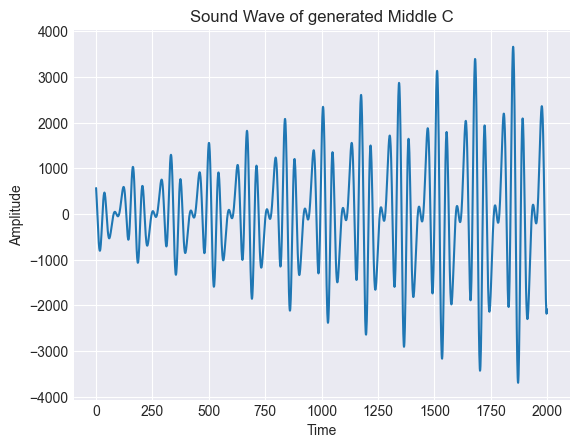

In [485]:
plt.plot(sax_note_with_adsr[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of generated Middle C')
plt.grid()

In [339]:
wavfile.write('data/sax_with_adsr_c.wav', rate=44100, data=sax_note_with_adsr.astype(np.int16))

### Attack, Sustain, Decay, Release

Refs: https://www.youtube.com/watch?v=9SMi47AEnSo

<br>

In [277]:
adsr_length = [0.001, 0.50, 0.55, 0.15]
decay = [0.075, 0.02, 0.005, 0.1]
sustain_level = 0.8

attack_time = 0.2
decay_time = 0.01
release_time = 0.01


In [279]:
adsr_result = apply_adsr(sax_note_with_overtones, sample_rate, attack_time, decay_time, sustain_level, release_time)


In [280]:
ipd.Audio(adsr_result, rate=sax_sample_rate, normalize=True)

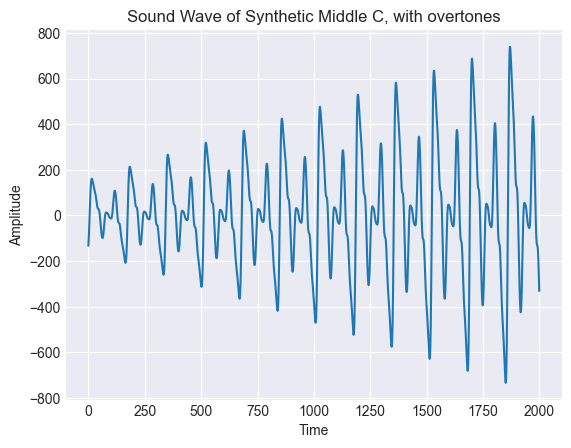

In [282]:
plt.plot(adsr_result[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of Synthetic Middle C, with overtones')
plt.grid()

## Formula 2

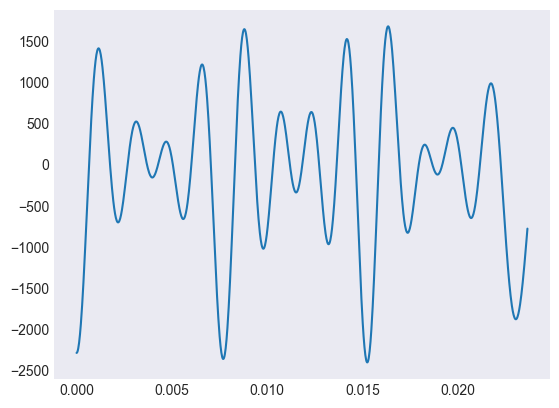

In [295]:
period, rate = extractPeriod(sax_middle_c, sax_sample_rate, 0.038, 0.073)
coefficients = fourierSeriesCoefficients(period, 20)
data = translate(len(period), coefficients)

t = np.arange(0, len(data[500:2500])) / sample_rate
plt.plot(t, data[500:2500])

In [284]:
ipd.Audio(data, rate=sax_sample_rate, normalize=True)

## Formula 3

In [486]:
# Extract harmonic data from the sax sound wave
harmonics_data = extract_harmonics(sax_middle_c, sample_rate)

fundamental_freq = estimate_fundamental_frequency(sax_middle_c, sample_rate)

# Apply the harmonics to the generated middle c sound wave
middle_c_harmonic = apply_harmonic_structure(middle_c, fundamental_freq, harmonics_data, sample_rate, 2.0)

# Get the envelope to apply to the sound wave using low pass filter
envelope = compute_envelope_lowpass(middle_c_harmonic, sample_rate, cutoff_freq=150, order=2)

# Apply the amplitude envelope
middle_c_envelope = apply_amplitude_envelope(middle_c_harmonic, envelope)

# Apply the adsr
middle_c_adsr = apply_adsr_envelope(middle_c_envelope, sample_rate, 0.1, 0.3, 0.7, 0.6)


In [487]:
ipd.Audio(middle_c_adsr, rate=sax_sample_rate, normalize=True)

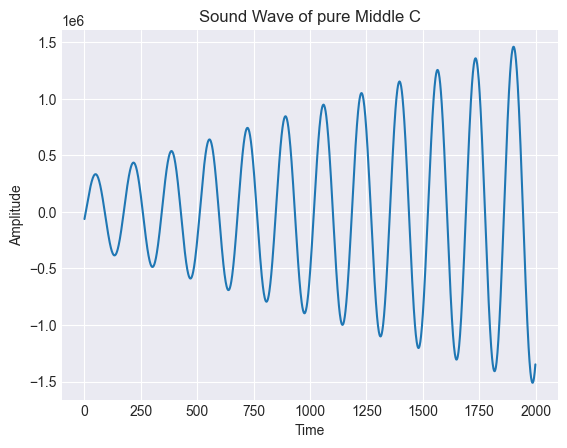

In [488]:
plt.plot(middle_c_adsr[500:2500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sound Wave of pure Middle C')
plt.grid()